# 划分 Wikipedia 学科, 使用 core 学科

In [16]:
import pymongo
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
from dotenv import dotenv_values
import tqdm
import collections

env_config = dotenv_values("../.env")

In [ ]:
# database_name = f"wikipedia_dump_v{env_config['WIKI_VERSION']}"
# wikipedia_stats_collection = pymongo.MongoClient(env_config['Mongo_Url'])[database_name]["degree_stats"]
# wikipedia_stats_collection.count_documents({})

In [3]:
database_name = f"wikipedia_dump_v{env_config['WIKI_VERSION']}"
wikipedia_collection = pymongo.MongoClient(env_config['Mongo_Url'])[database_name]["revision_complete"]
# wikipedia_collection.count_documents({})

In [18]:
# 找到所有存在 page linksin 的 category

# category_set = set()

# for doc in tqdm.tqdm(wikipedia_collection.find({'page_category_links_out':{'$ne':None}},{'page_category_links_out':1})):
#     category_set.update(doc['page_category_links_out'])

# len(category_set)

In [20]:
# 找到所有存在 page linksin 的 category

# category_set = set(wikipedia_collection.distinct('page_category_links_out'))
# len(category_set)

In [ ]:
# 找到匹配的条件的 category core name
subject_list = [ "Mathematics", "Physics", "Computer science", "Engineering disciplines", "Medicine",
		"Biology", "Chemistry", "Materials science", "Geology", "Geography", "Environmental science",
		"Economics", "Sociology", "Psychology", "Political science", "Philosophy", "Business", "Art",
		"History" ]

core_key_1 = ["Subfields of", "Areas of" "Fields of", "Branches of", "Subdivisions of"]

core_key_2 = ["by field", "by fields", "of field", "by specialty"]

subject_key_map = collections.defaultdict(set)
total_map = set()

for name in subject_list:
    subject_key_map[name] = set()
    low_name = name.lower()
    for key in core_key_2:
        subject_key_map[name].add(f"{low_name} {key.lower()}")
        total_map.add(f"{low_name} {key.lower()}")
    for key in core_key_1:
        subject_key_map[name].add(f"{key.lower()} {low_name}")
        total_map.add(f"{key.lower()} {low_name}")
    
    total_map.add(low_name)
        
# subject_key_map

In [ ]:
# 生成子学科到主学科的映射, 子学科区分大小写

# core cat
subject_core_cat_map = collections.defaultdict(set)

# 包含主学科的 cat set
subject_chief_cat_map = collections.defaultdict(set)

for cat_name in tqdm.tqdm(category_set):
    cat_name_lower = cat_name.lower()
    if cat_name_lower in total_map:
        for subject_name , cat_set in subject_key_map.items():
            if cat_name_lower in cat_set:
                subject_core_cat_map[subject_name].add(cat_name)
            elif cat_name_lower == subject_name.lower():
                subject_chief_cat_map[subject_name].add(cat_name)
     
reverse_subject_core_cat_map = {}
for name, items in subject_core_cat_map.items():
    for sub_name in items:
        reverse_subject_core_cat_map[sub_name] = name
        
reverse_subject_chief_cat_map = {}
for name, items in subject_chief_cat_map.items():
    for sub_name in items:
        reverse_subject_chief_cat_map[sub_name] = name

100%|██████████| 2526905/2526905 [00:01<00:00, 1454956.36it/s]


In [ ]:
# reverse_subject_chief_cat_map

# subject_core_cat_map
# subject_chief_cat_map

for name in subject_list:
    if name not in subject_core_cat_map:
        print(subject_chief_cat_map[name])

{'engineering disciplines', 'Engineering disciplines'}
{'Medicine', 'medicine'}
{'Materials science', 'Materials Science', 'materials science'}
{'Environmental science', 'Environmental Science'}
{'Business', 'business'}
{'Art'}


# 逻辑处理
要计算的学科子图

1. 一层 core subject category page (有多个都用一层), 无 core subject category 的就用一层 subject category page
2. 扩展到二层, 三层, 每年独立计算 category 层级

In [27]:
def get_category_range(year:int):
    
    # 找到当前所有的 category linksin
    category_set = set()
    for doc in wikipedia_collection.find({'ns':0,'year_tags':year, 'page_category_links_out':{'$ne':None}},{'page_category_links_out':1}):
        category_set.update(doc['page_category_links_out'])
    print(year, len(category_set))
    
    # 生成子学科到主学科的映射, 子学科区分大小写

    # core cat
    subject_core_cat_map = collections.defaultdict(set)

    # 包含主学科的 cat set
    subject_chief_cat_map = collections.defaultdict(set)

    for cat_name in tqdm.tqdm(category_set):
        cat_name_lower = cat_name.lower()
        if cat_name_lower in total_map:
            for subject_name , cat_set in subject_key_map.items():
                if cat_name_lower in cat_set:
                    subject_core_cat_map[subject_name].add(cat_name)
                elif cat_name_lower == subject_name.lower():
                    subject_chief_cat_map[subject_name].add(cat_name)
                    
    # 对没有 core cat 的学科进行补充
    for name in subject_list:
        if name not in subject_core_cat_map:
            for item in subject_chief_cat_map[name]:
                subject_core_cat_map[name].add(item)
    
    # 生成反向 map
    reverse_subject_core_cat_map = {}
    for name, items in subject_core_cat_map.items():
        for sub_name in items:
            reverse_subject_core_cat_map[sub_name] = name
            
    # 获取了当年的所有主学科和子学科的映射
    lv1_subject_dict = collections.defaultdict(set)
    lv2_subject_dict = collections.defaultdict(set)
    lv3_subject_dict = collections.defaultdict(set)
    
    # lv2
    for cat_name, subject_name in reverse_subject_core_cat_map.items():
        for doc in wikipedia_collection.find({'ns':14,'year_tags':year, 'page_category_links_out': cat_name}):
            sub_cat_name = doc['title'].split(":")[-1]
            lv2_subject_dict[subject_name].add(sub_cat_name)
            
    # lv3
    for subject_name, cat_name_list in lv2_subject_dict.items():
        for cat_name in cat_name_list:
            # lv3 包含lv2
            lv3_subject_dict[subject_name].add(cat_name)
            for doc in wikipedia_collection.find({'ns':14,'year_tags':year, 'page_category_links_out': cat_name}):
                sub_cat_name = doc['title'].split(":")[-1]
                lv3_subject_dict[subject_name].add(sub_cat_name)
    
    # lv1 
    for cat_name, subject_name in reverse_subject_core_cat_map.items():
        lv1_subject_dict[subject_name].add(cat_name)
        # lv2, lv3 包含 lv1
        lv2_subject_dict[subject_name].add(cat_name)
        lv3_subject_dict[subject_name].add(cat_name)
    
    return lv1_subject_dict, lv2_subject_dict, lv3_subject_dict


wikipedia_collection.create_index([('core_subject_tag', pymongo.ASCENDING)],background=True,sparse=True)

def calculate_yearly_subject_entropy(year:int):
    
    lv1_subject_dict, lv2_subject_dict, lv3_subject_dict = get_category_range(year)
    
    core_tag_map = collections.defaultdict(set)
    
    for subject_name, cat_name_list in lv1_subject_dict.items():
        for cat_name in cat_name_list:
            for doc in wikipedia_collection.find({'ns':0, 'page_category_links_out':cat_name, 'year_tags':year},{'_id':1}):
                core_tag_map[doc['_id']].add(f"lv1-{subject_name}-{year}")
                
    for subject_name, cat_name_list in lv2_subject_dict.items():
        for cat_name in cat_name_list:
            for doc in wikipedia_collection.find({'ns':0, 'page_category_links_out':cat_name, 'year_tags':year},{'_id':1}):
                core_tag_map[doc['_id']].add(f"lv2-{subject_name}-{year}")
                
    for subject_name, cat_name_list in lv3_subject_dict.items():
        for cat_name in cat_name_list:
            for doc in wikipedia_collection.find({'ns':0, 'page_category_links_out':cat_name, 'year_tags':year},{'_id':1}):
                core_tag_map[doc['_id']].add(f"lv3-{subject_name}-{year}")
          
    bulk_operate_list = []      
    for doc_id, tag_set in core_tag_map.items():
        bulk_operate_list.append(
            pymongo.UpdateOne(
                {'_id':doc_id},
                {'$addToSet':{'core_subject_tag':{"$each":list(tag_set)}}}
            )
        )
    wikipedia_collection.bulk_write(bulk_operate_list)
    print('bulk_operate_list', len(bulk_operate_list))
                
lv1_subject_dict, lv2_subject_dict, lv3_subject_dict = get_category_range(2023)

2023 1638406


100%|██████████| 1638406/1638406 [00:00<00:00, 1755686.93it/s]


In [29]:
lv2_subject_dict["Mathematics"]

{'Eponyms in mathematics',
 'Fields of mathematics',
 'History of mathematics',
 'Mathematical classification systems',
 'Mathematical concepts',
 'Mathematical constants',
 'Mathematical examples',
 'Mathematical notation',
 'Mathematical projects',
 'Mathematical proofs',
 'Mathematical science occupations',
 'Mathematical terminology',
 'Mathematical theorems',
 'Mathematical tools',
 'Mathematicians',
 'Mathematics',
 'Mathematics and art',
 'Mathematics and culture',
 'Mathematics by country',
 'Mathematics-related lists',
 'Outlines of mathematics and logic',
 'Philosophy of mathematics',
 'Pseudomathematics',
 'Set index articles on mathematics',
 'Statistical concepts',
 'Works about mathematics'}

In [26]:

# 测试成功
for year in range(2003,2024+1):
    calculate_yearly_subject_entropy(year)

2003 22


100%|██████████| 22/22 [00:00<00:00, 117248.65it/s]

bulk_operate_list 1


2004 36037


100%|██████████| 36037/36037 [00:00<00:00, 1612319.68it/s]


bulk_operate_list 22602
2005 85012


100%|██████████| 85012/85012 [00:00<00:00, 1606877.75it/s]


bulk_operate_list 47367
2006 171153


100%|██████████| 171153/171153 [00:00<00:00, 1514048.05it/s]


bulk_operate_list 60992
2007 262895


100%|██████████| 262895/262895 [00:00<00:00, 1530522.05it/s]


bulk_operate_list 78648
2008 348682


100%|██████████| 348682/348682 [00:00<00:00, 1715655.94it/s]


bulk_operate_list 101955
2009 427088


100%|██████████| 427088/427088 [00:00<00:00, 1569625.71it/s]


bulk_operate_list 112129
2010 517027


100%|██████████| 517027/517027 [00:00<00:00, 1581255.38it/s]


bulk_operate_list 120845
2011 623140


100%|██████████| 623140/623140 [00:00<00:00, 1661897.91it/s]


bulk_operate_list 113086
2012 711986


100%|██████████| 711986/711986 [00:00<00:00, 1736511.47it/s]


bulk_operate_list 124422
2013 813709


100%|██████████| 813709/813709 [00:00<00:00, 1691636.65it/s]


bulk_operate_list 120953
2014 896642


100%|██████████| 896642/896642 [00:00<00:00, 1716697.19it/s]


bulk_operate_list 123072
2015 992983


100%|██████████| 992983/992983 [00:00<00:00, 1735043.31it/s]


bulk_operate_list 131418
2016 1085536


100%|██████████| 1085536/1085536 [00:00<00:00, 1775310.56it/s]


bulk_operate_list 125021
2017 1174384


100%|██████████| 1174384/1174384 [00:00<00:00, 1763889.62it/s]


bulk_operate_list 124077
2018 1250712


100%|██████████| 1250712/1250712 [00:00<00:00, 1702355.50it/s]


bulk_operate_list 125717
2019 1326529


100%|██████████| 1326529/1326529 [00:00<00:00, 1732186.95it/s]


bulk_operate_list 131838
2020 1415147


100%|██████████| 1415147/1415147 [00:00<00:00, 1724705.00it/s]


bulk_operate_list 150929
2021 1492281


100%|██████████| 1492281/1492281 [00:00<00:00, 1674336.08it/s]


bulk_operate_list 154574
2022 1562671


100%|██████████| 1562671/1562671 [00:00<00:00, 1703909.76it/s]


bulk_operate_list 152393
2023 1638406


100%|██████████| 1638406/1638406 [00:01<00:00, 1498131.22it/s]


bulk_operate_list 144258
2024 1715068


100%|██████████| 1715068/1715068 [00:01<00:00, 1680155.43it/s]


bulk_operate_list 148805


# 熵的统计

In [45]:
import collections

subject_entropy_collection = pymongo.MongoClient(env_config['Mongo_Url'])[database_name]["subject_entropy"]

start_year, end_year = 2005,2024
year_range = [year for year in range(start_year, end_year+1)]

def get_wikipeida_entropy_data(level, subject):
    entropy_data_map = collections.defaultdict(lambda: np.full(end_year - start_year + 1,np.nan))
    for doc in subject_entropy_collection.find({'subject':subject, 'level':level}):
        index = doc['year'] - start_year
        if index < 0:
            continue
        if "struct" == doc['entropyType']:
            key = f"Structural Entropy"
            entropy_data_map[key][index] = doc['entropy']['entropyin'] if doc['graphSize'] != 0 else np.nan
            key = f"Normalized Structural Entropy"
            entropy_data_map[key][index] = doc['entropy']['normalizeentropyin'] if doc['graphSize'] != 0 else np.nan
            
            key = "Graph Size(Structural Entropy)"
            entropy_data_map[key][index] = doc['entropy']['nodeincount'] if doc['graphSize'] != 0 else np.nan
            
        elif  "degree" == doc['entropyType']:
            key = f"Degree Distribution Entropy"
            entropy_data_map[key][index] = doc['entropy']['entropyin'] if doc['graphSize'] != 0 else np.nan
            
            key = "Graph Size(Degree Distribution Entropy)"
            entropy_data_map[key][index] = doc['entropy']['nodecount'] if doc['graphSize'] != 0 else np.nan
            
    return entropy_data_map

In [33]:
# get_wikipeida_entropy_data(3, 'Mathematics')

In [12]:
subject_list

['Mathematics',
 'Physics',
 'Computer science',
 'Engineering disciplines',
 'Medicine',
 'Biology',
 'Chemistry',
 'Materials science',
 'Geology',
 'Geography',
 'Environmental science',
 'Economics',
 'Sociology',
 'Psychology',
 'Political science',
 'Philosophy',
 'Business',
 'Art',
 'History']

In [35]:

def custom_formatter(x, pos):
    return '{:,}'.format(int(x))

In [34]:
import pandas as pd
dataframe_list = []

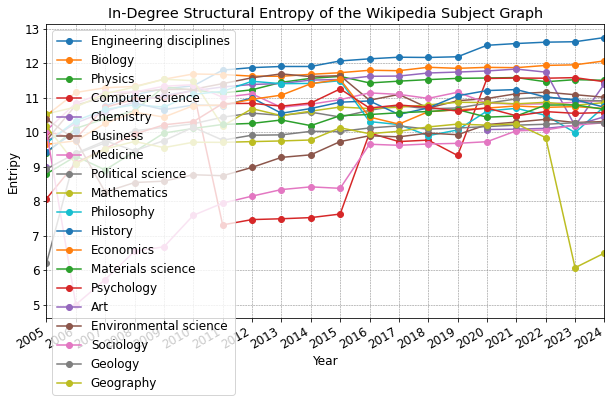

In [46]:
# In-Degree Structural Entropy of the Wikipedia Graph


plt.rcParams['font.size'] = 12
fig, ax1 = plt.subplots(figsize=(10, 6))

key = "Structural Entropy"

data = {}
for subject in subject_list:

    entropy_data_map = get_wikipeida_entropy_data(3, subject)
    
    label=subject
    # ax1.plot(year_range, entropy_data_map[key], label=label, marker='o')  
    data[label] = entropy_data_map[key]
    
df = pd.DataFrame(data, index=year_range)
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]

dataframe_list.append((df, key))
df.plot(ax=ax1, marker='o')
    
ax1.set_xlim(start_year, end_year)
ax1.set_xticks(year_range)
ax1.set_xlabel('Year')
ax1.set_ylabel('Entripy')
    
ax1.legend()
plt.title(f"In-Degree {key} of the Wikipedia Subject Graph")

formatter = FuncFormatter(custom_formatter)
ax1.yaxis.set_major_formatter(formatter)

plt.grid(True, axis='both' , which='both', linestyle='--', linewidth=0.5, color='gray')
plt.gcf().autofmt_xdate()
plt.show()


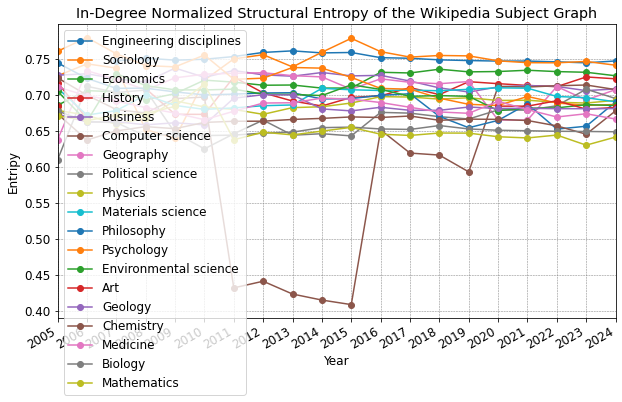

In [48]:
# In-Degree Structural Entropy of the Wikipedia Graph


plt.rcParams['font.size'] = 12
fig, ax1 = plt.subplots(figsize=(10, 6))

key = "Normalized Structural Entropy"

data = {}
for subject in subject_list:

    entropy_data_map = get_wikipeida_entropy_data(3, subject)
    
    label=subject
    # ax1.plot(year_range, entropy_data_map[key], label=label, marker='o')  
    data[label] = entropy_data_map[key]
    
df = pd.DataFrame(data, index=year_range)
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]

dataframe_list.append((df, key))
df.plot(ax=ax1, marker='o')
    
ax1.set_xlim(start_year, end_year)
ax1.set_xticks(year_range)
ax1.set_xlabel('Year')
ax1.set_ylabel('Entripy')
    
ax1.legend()
plt.title(f"In-Degree {key} of the Wikipedia Subject Graph")

# formatter = FuncFormatter(custom_formatter)
# ax1.yaxis.set_major_formatter(formatter)

plt.grid(True, axis='both' , which='both', linestyle='--', linewidth=0.5, color='gray')
plt.gcf().autofmt_xdate()
plt.show()


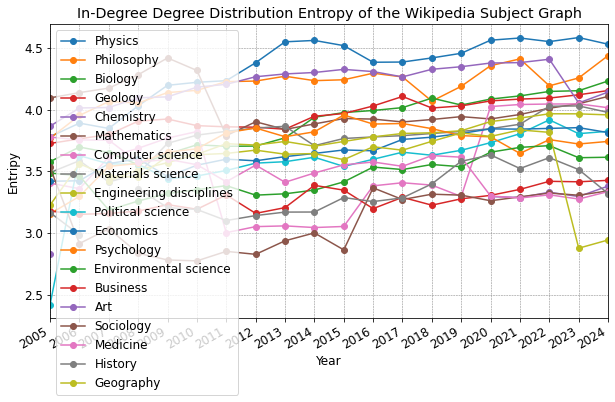

In [49]:


# In-Degree Structural Entropy of the Wikipedia Graph


plt.rcParams['font.size'] = 12
fig, ax1 = plt.subplots(figsize=(10, 6))

key = "Degree Distribution Entropy"

data = {}
for subject in subject_list:

    entropy_data_map = get_wikipeida_entropy_data(3, subject)
    
    label=subject
    # ax1.plot(year_range, entropy_data_map[key], label=label, marker='o')  
    data[label] = entropy_data_map[key]
    
df = pd.DataFrame(data, index=year_range)
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]

dataframe_list.append((df, key))
df.plot(ax=ax1, marker='o')
    
ax1.set_xlim(start_year, end_year)
ax1.set_xticks(year_range)
ax1.set_xlabel('Year')
ax1.set_ylabel('Entripy')
    
ax1.legend()
plt.title(f"In-Degree {key} of the Wikipedia Subject Graph")

# formatter = FuncFormatter(custom_formatter)
# ax1.yaxis.set_major_formatter(formatter)

plt.grid(True, axis='both' , which='both', linestyle='--', linewidth=0.5, color='gray')
plt.gcf().autofmt_xdate()
plt.show()


In [ ]:
# 任务升级, 子学科在此处处理, 存入数据库
# 2个 level, 1. 只有 core 学科, 
# key: subject, year, coreType:[1: core, 2: cat] 

def detect_subject(cat_out: list[str]):
    lv1_match = set()
    lv2_match = set()
    for name in cat_out:
        core_cat = reverse_subject_core_cat_map.get(name)
        if core_cat:
           lv1_match.add(core_cat)
        else:
            total_cat = reverse_subject_total_cat_map.get(name)
            if total_cat:
                lv2_match.add(total_cat)
    return list(lv1_match), list(lv2_match)
        
        

def get_year_revision(year: int):
    wikipedia_subject_collection = pymongo.MongoClient(env_config['Mongo_Url'])[database_name][f"subject_revision_{year}"]
    doc_cache = []
    for doc in tqdm.tqdm(wikipedia_collection.find({'year_tags':year, 'page_category_links_out':{'$ne':None}})):
        lv1_match, lv2_match = detect_subject(doc['page_category_links_out'])
        if lv1_match or lv2_match:
            doc["core_subject"] = lv1_match
            doc["core_subject_mx"] = lv2_match
            doc_cache.append(doc)
            if len(doc_cache) > 10000:
                wikipedia_subject_collection.insert_many(doc_cache)
                doc_cache = []
            
    if doc_cache:
        wikipedia_subject_collection.insert_many(doc_cache)
        doc_cache = []
        
for year in range(2002,2024+1):
    get_year_revision(year)